In [1]:
# !pip install duckdb

In [2]:
import pandas as pd 
import duckdb
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [3]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["878fb3","3d3f5e","dbdeee","af97ca","6c6c84","a5aac9","a2a4ab","4daaa0","727474"])
mpl.rcParams['figure.figsize'] = [5,4]

In [4]:
con = duckdb.connect()
con.execute("INSTALL 'sqlite'")
con.execute("LOAD 'sqlite'");

In [5]:
con = duckdb.connect(database='interview_database_20231023_204043.db', read_only=True)

In [6]:
con.execute("select * from sqlite_master where type='table'").fetchdf()

type             name         tbl_name  rootpage  \
0  table    organizations    organizations         0   
1  table            users            users         0   
2  table         accounts         accounts         0   
3  table     transactions     transactions         0   
4  table  fraud_decisions  fraud_decisions         0   

                                                 sql  
0  CREATE TABLE organizations(ID VARCHAR PRIMARY ...  
1  CREATE TABLE users(id VARCHAR PRIMARY KEY, cre...  
2  CREATE TABLE accounts(ID VARCHAR PRIMARY KEY, ...  
3  CREATE TABLE transactions(id VARCHAR PRIMARY K...  
4  CREATE TABLE fraud_decisions(accounts_id VARCH...

In [7]:
organizations = con.execute(
    """
select ID,
       website,
       created_at,
       is_active,
       country,
       industry,
       strftime('%Y-%m', created_at) AS year_month
from organizations
    """
                           ).fetchdf()

In [8]:
# added an additional column not in original data
organizations.columns == ['ID','website', 'created_at', 'is_active','country', 'industry', 'year-month']

array([ True,  True,  True,  True,  True,  True, False])

In [9]:
organizations.head()

ID         website  \
0  org_aa2f3bdd-f530-4bfe-bbae-ac0f6fb8edae  www.852eb4.com   
1  org_a899857e-5465-4960-9c8b-ae669652dde8            None   
2  org_52cc799b-2e29-4d1c-a52f-8cdb05e78c27            None   
3  org_f0b5e4d0-5b33-42ab-8da5-d0a8f7c55ccc            None   
4  org_71abe4a2-f6ac-4d81-a19a-d963e32b59be  www.c59c89.com   

                  created_at  is_active country  industry year_month  
0 2023-01-01 00:00:00.000000          1      GB     other    2023-01  
1 2023-01-03 18:10:54.545454          1      GB  software    2023-01  
2 2023-01-06 12:21:49.090909          1      AU     legal    2023-01  
3 2023-01-09 06:32:43.636363          1      GB     legal    2023-01  
4 2023-01-12 00:43:38.181818          1      DE    crypto    2023-01

In [10]:
def quality_report(df):
    """
    generates a quality report for a DataFrame.
    :param df: A pandas DataFrame.
    :return: A pandas Dataframe containing a quality report
    """
    dqr = pd.DataFrame(df.dtypes, columns=['dtype'])
    dqr['count'] = df.count()
    dqr['missing'] = df.isnull().sum()
    dqr['unique'] = df.nunique()
    minimum_values = pd.Series()
    maximum_values = pd.Series()
    for v in list(df.columns.values):
        try:
            minimum_values.loc[v] = df[v].min()
            maximum_values.loc[v] = df[v].max()
        except TypeError:
            minimum_values.loc[v] = df[v].astype(str).min()
            maximum_values.loc[v] = df[v].astype(str).max()
    dqr['min'] = minimum_values
    dqr['max'] = maximum_values
        
    return dqr
    

In [11]:
quality_report(organizations)

dtype  count  missing  unique  \
ID                  object    100        0     100   
website             object     35       65      35   
created_at  datetime64[us]    100        0     100   
is_active            int64    100        0       2   
country             object    100        0       5   
industry            object     90       10       5   
year_month          object    100        0      10   

                                                 min  \
ID          org_0474797d-60ce-4c9e-9d7d-dd2ede7b5a5a   
website                                         None   
created_at                       2023-01-01 00:00:00   
is_active                                          0   
country                                           AU   
industry                                        None   
year_month                                   2023-01   

                                                 max  
ID          org_fbc69a9d-a5a2-4d97-80b0-14f7081c2995  
website                               www.ffd2f4.com  
created_at                       2023-10-01 00:00:00  
is_active                                          1  
country                                           US  
industry                                    software  
year_month                                   2023-10

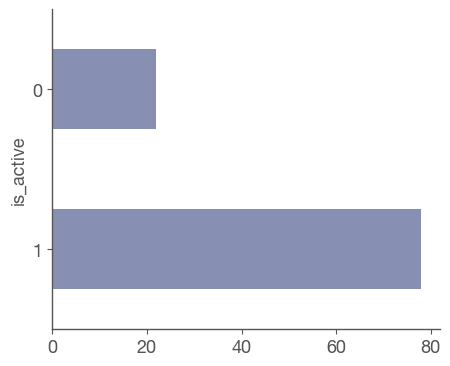

In [12]:
organizations.is_active.value_counts(dropna=False).plot.barh();

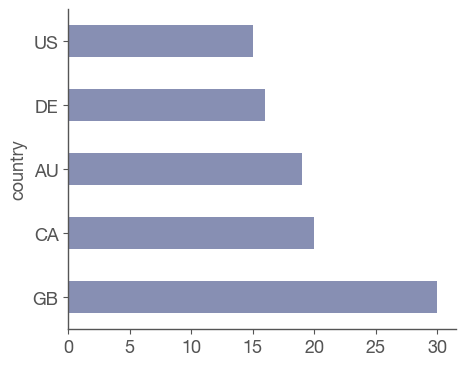

In [13]:
organizations.country.value_counts(dropna=False).plot.barh();

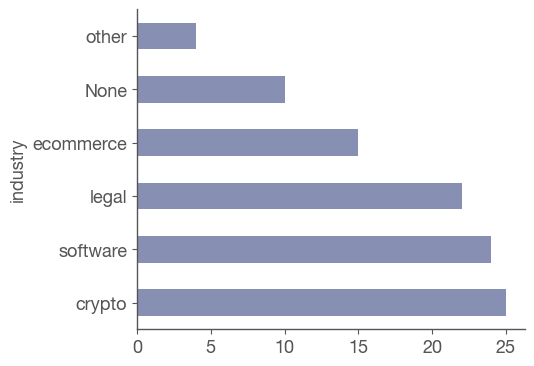

In [14]:
organizations.industry.value_counts(dropna=False).plot.barh();

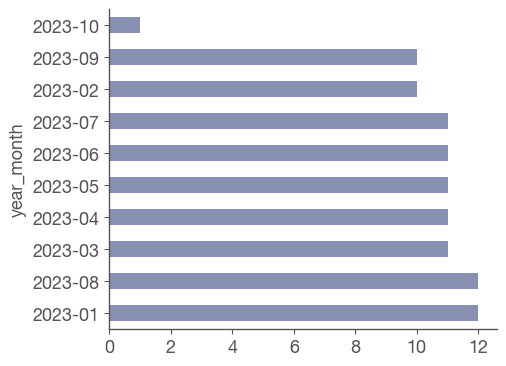

In [15]:
organizations.year_month.value_counts(dropna=False).plot.barh();

In [16]:
users = con.execute(
    """
select *
from users
    """
                           ).fetchdf()

In [17]:
#columns match schema definition
users.columns == ['id','created_at','first_name', 'last_name', 
                          'email', 'is_primary_user', 'organization_id']

array([ True,  True,  True,  True,  True,  True,  True])

In [18]:
quality_report(users)

dtype  count  missing  unique  \
id                       object    500        0     500   
created_at       datetime64[us]    500        0     500   
first_name               object    500        0       5   
last_name                object    500        0       5   
email                    object    484       16     172   
is_primary_user           int64    500        0       2   
organization_id          object    500        0      98   

                                                      min  \
id               usr_00236c48-c5ba-49ac-9677-2f03841bd3f8   
created_at                            2023-01-01 00:00:00   
first_name                                          Alice   
last_name                                           Brown   
email                                                None   
is_primary_user                                         0   
organization_id  org_0474797d-60ce-4c9e-9d7d-dd2ede7b5a5a   

                                                      max  
id               usr_ff9b3433-aafb-4e7b-a958-0970c3a679da  
created_at                            2023-10-01 00:00:00  
first_name                                          Emily  
last_name                                        Williams  
email                            emily.williams@yahoo.com  
is_primary_user                                         1  
organization_id  org_fbc69a9d-a5a2-4d97-80b0-14f7081c2995

In [19]:
users.head()

id                 created_at  \
0  usr_ed531fa3-d026-40b5-b325-918fa7208e96 2023-01-01 00:00:00.000000   
1  usr_e4bc8c0d-a0d9-423e-883a-ec1a1ca8a6c5 2023-01-01 13:07:48.937875   
2  usr_56593a23-af73-40db-bea1-a6c197a45767 2023-01-02 02:15:37.875751   
3  usr_1ef8ca2b-42b6-4546-a22b-5fa3c1f961ce 2023-01-02 15:23:26.813627   
4  usr_459dd902-7115-4806-b0c3-4bd2ea9e1df7 2023-01-03 04:31:15.751503   

  first_name last_name                     email  is_primary_user  \
0    Charlie     Brown   charlie.brown@gmail.com                0   
1    Charlie     Smith   charlie.smith@yahoo.com                1   
2        Bob  Williams    bob.williams@gmail.com                1   
3        Bob     Brown      bob.brown@4225af.com                1   
4      Alice  Williams  alice.williams@yahoo.com                1   

                            organization_id  
0  org_faf4d9ec-f9a7-4846-9104-0e8f4d5bb4c7  
1  org_df4addab-47a4-41a4-88d0-1e6889919b5e  
2  org_559d940e-b1bd-4b1a-8ed9-3a8b1363a33c  
3  org_1a5c3e56-5740-4907-b958-1a77d8f01aee  
4  org_a83865a8-de2a-43d5-8b13-310574df50ea

In [20]:
users.shape

(500, 7)

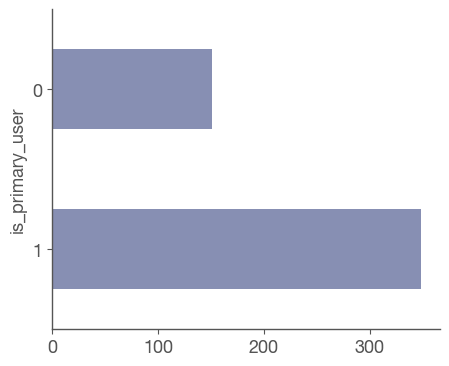

In [21]:
users.is_primary_user.value_counts().plot.barh();

In [22]:
accounts = con.execute(
    """
select *
from accounts
    """
                           ).fetchdf()

In [23]:
# schema matches definition
accounts.columns == ['ID', 'organization_id', 'account_type', 'created_at', 'is_closed']

array([ True,  True,  True,  True,  True])

In [24]:
quality_report(accounts)

dtype  count  missing  unique  \
ID                       object   2000        0    2000   
organization_id          object   2000        0     100   
account_type             object   2000        0       2   
created_at       datetime64[us]   2000        0    2000   
is_closed                 int64   2000        0       2   

                                                        min  \
ID               accts_00168de9-3f72-4827-a214-1bfa3855ddf2   
organization_id    org_0474797d-60ce-4c9e-9d7d-dd2ede7b5a5a   
account_type                                       Checking   
created_at                              2023-01-01 00:00:00   
is_closed                                                 0   

                                                        max  
ID               accts_fffd15b5-f7aa-486d-b9a4-10bd80244e6f  
organization_id    org_fbc69a9d-a5a2-4d97-80b0-14f7081c2995  
account_type                                        Savings  
created_at                              2023-10-01 00:00:00  
is_closed                                                 1

In [25]:
accounts.head()

ID  \
0  accts_92234fc1-acc4-44c8-aacd-026e4b190646   
1  accts_a6fd26a3-ca23-4c82-a403-e0fe6efd58a8   
2  accts_5b0889dc-d754-47ec-ac56-18d549f1e80b   
3  accts_3c49a262-8d2f-4d58-9e71-e89c929ede57   
4  accts_016d5575-a4f2-4809-99a9-c47b1657ec08   

                            organization_id account_type  \
0  org_f6c17f07-1f2b-4476-901d-bff4aa03f313      Savings   
1  org_daa09c2c-3791-4e81-b692-17b7b8a7399f      Savings   
2  org_db323b30-c28d-4643-b078-5428abfe71ae     Checking   
3  org_088acbab-cabf-4b98-bd0e-9b4baff0a5cd     Checking   
4  org_559d940e-b1bd-4b1a-8ed9-3a8b1363a33c     Checking   

                  created_at  is_closed  
0 2023-01-01 00:00:00.000000          1  
1 2023-01-01 03:16:39.499749          0  
2 2023-01-01 06:33:18.999499          0  
3 2023-01-01 09:49:58.499249          0  
4 2023-01-01 13:06:37.998999          1

In [26]:
accounts.shape

(2000, 5)

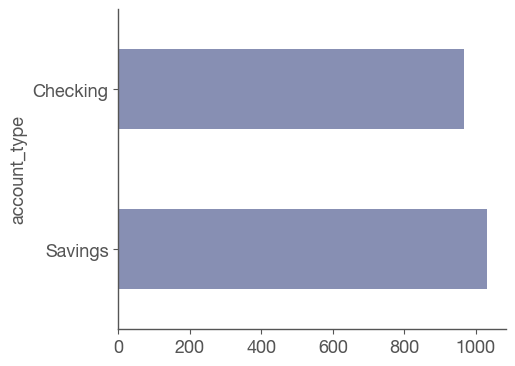

In [27]:
accounts.account_type.value_counts().plot.barh();

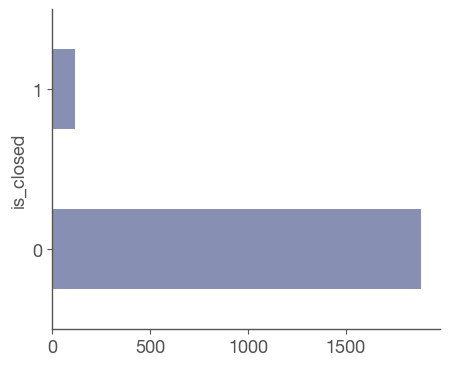

In [28]:
accounts.is_closed.value_counts().plot.barh();

In [29]:
transactions = con.execute(
    """
select *
from transactions
    """
                           ).fetchdf()

In [30]:
# columns match provided schema
transactions.columns == ['id', 'accounts_id', 'created_at', 'settled_at', 'status', 'amount']

array([ True,  True,  True,  True,  True,  True])

In [31]:
quality_report(transactions)

dtype  count  missing  unique  \
id                   object   2000        0    2000   
accounts_id          object   2000        0    1266   
created_at   datetime64[us]   2000        0    1994   
settled_at   datetime64[us]   2000        0    1999   
status               object   2000        0       2   
amount              float64   2000        0    1898   

                                                    min  \
id             txn_000c3d0c-6e97-47a2-86f3-d778f3d2a413   
accounts_id  accts_00168de9-3f72-4827-a214-1bfa3855ddf2   
created_at                          2023-01-01 07:34:00   
settled_at                          2023-01-01 08:18:00   
status                                        completed   
amount                                          -9999.0   

                                                    max  
id             txn_ffed63a3-5246-4b70-87da-9f3f72dce89c  
accounts_id  accts_ffc63c9c-f185-4287-b324-fdf9902c3892  
created_at                          2023-09-30 18:34:00  
settled_at                          2023-09-30 18:42:00  
status                                           failed  
amount                                           9998.0

In [32]:
transactions.head()

id  \
0  txn_6c1d6464-16f2-49ab-992e-81ebde7c81fb   
1  txn_584e8e1d-ca48-49a4-b177-06b371950c0a   
2  txn_cd135ce4-ae09-429f-a17d-315952b2384b   
3  txn_eee91bd7-8d47-4559-8dd1-882fceea411e   
4  txn_74d7d177-d18b-47e6-981c-4f686b5edd5b   

                                  accounts_id          created_at  \
0  accts_b7f8877d-307d-4669-a312-2b0cda63dbb9 2023-03-24 06:37:00   
1  accts_49438ca4-9618-44a3-889f-bba3f74c361c 2023-02-05 08:45:00   
2  accts_8196b52b-36f0-486c-bc29-eea4e338cfe6 2023-06-04 15:25:00   
3  accts_be2d4b98-95b1-4840-8079-8d5b2a06aac8 2023-04-05 18:04:00   
4  accts_dee6e8d5-505a-4a37-ba6d-1b253b74d526 2023-04-04 19:51:00   

           settled_at     status  amount  
0 2023-03-24 07:05:00  completed -1140.0  
1 2023-02-05 08:59:00     failed -8274.0  
2 2023-06-04 16:16:00  completed   658.0  
3 2023-04-05 18:17:00     failed -5209.0  
4 2023-04-04 20:48:00     failed -6625.0

In [101]:
transactions.id.nunique()

2000

In [33]:
transactions.shape

(2000, 6)

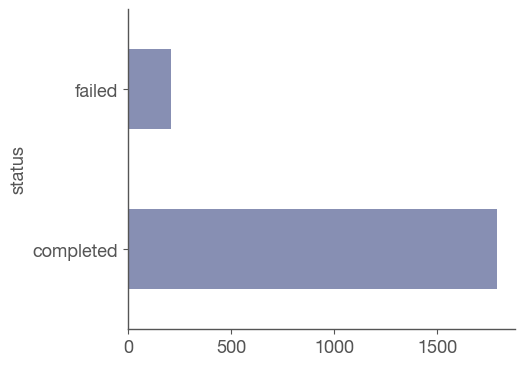

In [34]:
transactions.status.value_counts().plot.barh();

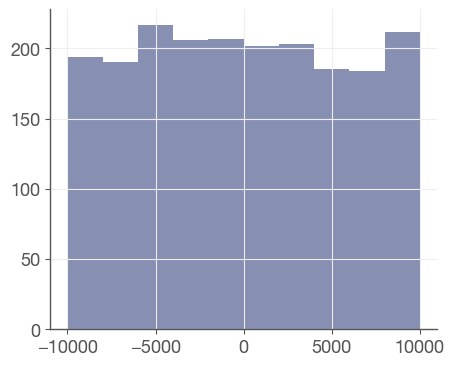

In [35]:
transactions.amount.hist();

In [36]:
fraud_decisions = con.execute(
    """
select *
from fraud_decisions
    """
                           ).fetchdf()

In [37]:
# columns are out of order also boolean field has been changed to 0,1
# TODO: better schema checks
fraud_decisions.columns == ['ID', 'txn_id', 'accounts_id', 'created_at', 
                            'reviewer_id', 'is_false_positive', 'decision']

array([False,  True, False, False, False, False, False])

In [38]:
quality_report(fraud_decisions)

dtype  count  missing  unique  \
accounts_id                object   2562        0     380   
txn_id                     object   2562        0     507   
created_at         datetime64[us]    592     1970     592   
reviewer_id                object   2562        0       5   
is_false_positive           int64   2562        0       2   
decision                   object   2562        0       2   
id                         object   2562        0    2562   

                                                          min  \
accounts_id        accts_003bc21b-6fd8-48c2-a516-751178c9b739   
txn_id               txn_0012662f-12c7-4b54-b72d-244446769eb1   
created_at                         2023-01-04 08:45:30.022155   
reviewer_id                                             Alice   
is_false_positive                                           0   
decision                                                Fraud   
id                   frd_002894bf-a6ba-465d-820c-548d610d7c81   

                                                          max  
accounts_id        accts_ffc63c9c-f185-4287-b324-fdf9902c3892  
txn_id               txn_ff14ff78-f1fa-423b-a5fb-06e53fd7e804  
created_at                         2023-09-28 14:30:04.178683  
reviewer_id                                              John  
is_false_positive                                           1  
decision                                           Legitimate  
id                   frd_ffe6af29-4ce2-495c-9b34-c0a6fbad19ad

In [39]:
fraud_decisions.head()

accounts_id  \
0  accts_003bc21b-6fd8-48c2-a516-751178c9b739   
1  accts_003bc21b-6fd8-48c2-a516-751178c9b739   
2  accts_003bc21b-6fd8-48c2-a516-751178c9b739   
3  accts_003bc21b-6fd8-48c2-a516-751178c9b739   
4  accts_003bc21b-6fd8-48c2-a516-751178c9b739   

                                     txn_id                 created_at  \
0  txn_3f5267a4-ee2e-4e9a-90fd-3786bbdaf4ea 2023-05-24 21:05:07.049670   
1  txn_3f5267a4-ee2e-4e9a-90fd-3786bbdaf4ea 2023-05-24 21:38:13.177078   
2  txn_3f5267a4-ee2e-4e9a-90fd-3786bbdaf4ea 2023-05-24 23:09:58.418121   
3  txn_3f5267a4-ee2e-4e9a-90fd-3786bbdaf4ea 2023-05-24 21:22:18.879544   
4  txn_3f5267a4-ee2e-4e9a-90fd-3786bbdaf4ea 2023-05-24 22:15:31.714867   

  reviewer_id  is_false_positive    decision  \
0         Bob                  0  Legitimate   
1       David                  0  Legitimate   
2       Alice                  0  Legitimate   
3       David                  0  Legitimate   
4       David                  0  Legitimate   

                                         id  
0  frd_580adb14-7071-492c-ace7-80837830b99b  
1  frd_fa5be20b-86fb-457d-8e0b-eb838164e7e9  
2  frd_f786440a-d664-4667-8d95-a5d933b49eac  
3  frd_866ac272-a122-4ba0-b907-47f7239a9525  
4  frd_2b546074-ea5e-4277-8ea6-5e4bb58f62ad

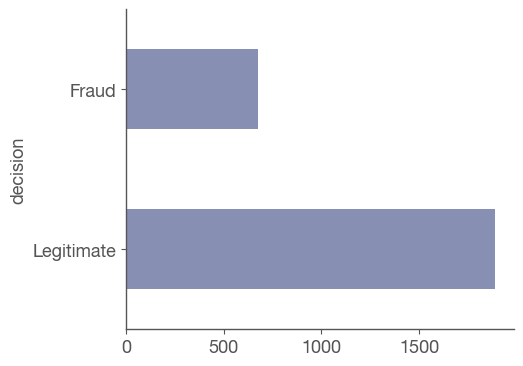

In [40]:
fraud_decisions.decision.value_counts().plot.barh();

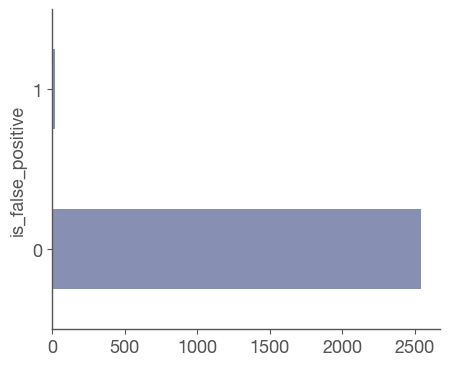

In [41]:
fraud_decisions.is_false_positive.value_counts().plot.barh();

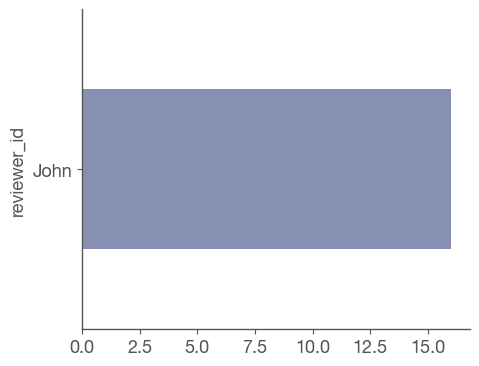

In [273]:
fraud_decisions.query("is_false_positive==1").reviewer_id.value_counts().plot.barh();

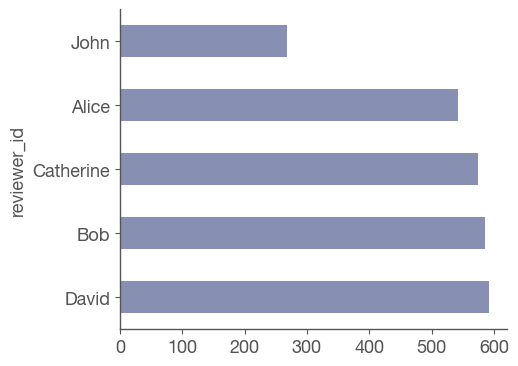

In [42]:
fraud_decisions.reviewer_id.value_counts().plot.barh();

In [43]:
fraud_decisions.groupby(['decision']).txn_id.nunique()

decision
Fraud         156
Legitimate    374
Name: txn_id, dtype: int64

TODO:
- join together
- create some features
- correlation
- automated machine learning

In [44]:
transactions.columns

Index(['id', 'accounts_id', 'created_at', 'settled_at', 'status', 'amount'], dtype='object')

In [269]:
con.execute("""
select organization_id,
       created_at,
       id,
       email,
           count(distinct id) as org_num_users,
    count(distinct case when email is not null then id end) as org_num_users,
    1.0*count(distinct case when email is not null then id end)/count(distinct id) as ratio_users_with_email,
    min(created_at) as min_usr_created_at,
    max(created_at) as max_usr_created_at
from users
where organization_id in ('org_b71e1a88-24ae-41d2-b46c-cdf5ae011d78')

""").fetchdf()

organization_id                 created_at  \
0  org_b71e1a88-24ae-41d2-b46c-cdf5ae011d78 2023-02-23 14:45:55.911823   
1  org_b71e1a88-24ae-41d2-b46c-cdf5ae011d78 2023-03-15 07:27:17.675350   
2  org_b71e1a88-24ae-41d2-b46c-cdf5ae011d78 2023-04-14 09:37:09.258517   
3  org_b71e1a88-24ae-41d2-b46c-cdf5ae011d78 2023-05-29 06:18:02.164328   

                                         id                     email  
0  usr_3e2b4b0c-1bcf-49fc-94f1-27d9a6295c15    bob.williams@yahoo.com  
1  usr_1c5bd4b6-f7a9-4430-8309-eefd39458b15  charlie.jones@c59c89.com  
2  usr_7980e3f2-d0c9-4bee-91ce-c327a258addd    emily.brown@582f33.com  
3  usr_53aa8cd0-b996-4d29-b719-7a1c4c4bd264      bob.brown@6124ed.com

In [268]:
con.execute(
    """
with decisions as (
  select
    txn_id,
    accounts_id,
    max(case when decision = 'Fraud' then 1 else 0 end) as is_fraud,
    max(case when decision = 'Legitimate' then 1 else 0 end) as is_legitimate,
    max(is_false_positive) as is_false_positive,
    max(created_at) as max_created_at,
    min(created_at) as min_created_at,
    count(*) as total_decisions
  from
    fraud_decisions
  group by
    txn_id,
    accounts_id
)
select
   txn.accounts_id,
   txn.created_at as txn_created_at,
   txn.settled_at as txn_settled_at,
   strftime('%H', txn.created_at)::int as txn_created_at_hr,
   (julian(txn.settled_at) - julian(txn.created_at))*24*60 as settlement_time_mins,
   txn.status as txn_status,
   txn.amount as txn_amount,
   case
        when txn.amount > 0 then 'credit'
        when txn.amount < 0 then 'debit'
   end as txn_type,
   org.id as org_id
   accts.account_type,
   accts.created_at as accts_created_at,
   accts.is_closed as accts_is_closed,
   org.website as org_website,
  case
    when org.website is not null then 1 else 0
  end as org_has_website,
  org.created_at as org_created_at,
  org.is_active as org_is_active,
  org.country as org_country,
  case when org.industry is null then 'industry unavailable' else org.industry end as org_industry,
  (julian(txn.created_at) - julian(accts.created_at)) as acct_tenure_days,
  (julian(txn.created_at) - julian(org.created_at)) as org_tenure_days,
   count( case when txn.status = 'failed' then txn.id end) over(partition by txn.accounts_id 
   order by txn.created_at
   rows between unbounded preceding and 1 preceding) as failed_txn_cnt,
   count(txn.id) over(partition by txn.accounts_id order by txn.created_at  rows between unbounded preceding and 1 preceding) as txn_count,
   failed_txn_cnt/txn_count as acct_failure_rate,
  decisions.is_fraud,
  decisions.is_legitimate,
  decisions.is_false_positive,
  decisions.max_created_at as frd_max_created_at,
  decisions.min_created_at as frd_min_created_at
  from
    transactions txn
    left join accounts as accts on txn.accounts_id = accts.id
    left join organizations as org on accts.organization_id = org.id
    left join decisions on txn.id = decisions.txn_id and txn.accounts_id = decisions.accounts_id
where txn.accounts_id in ('accts_49438ca4-9618-44a3-889f-bba3f74c361c')
    """
).fetchdf()

accounts_id      txn_created_at  \
0  accts_49438ca4-9618-44a3-889f-bba3f74c361c 2023-01-02 13:10:00   
1  accts_49438ca4-9618-44a3-889f-bba3f74c361c 2023-02-05 08:45:00   
2  accts_49438ca4-9618-44a3-889f-bba3f74c361c 2023-07-10 00:52:00   

       txn_settled_at  txn_created_at_hr  settlement_time_mins txn_status  \
0 2023-01-02 13:26:00                 13                  16.0     failed   
1 2023-02-05 08:59:00                  8                  14.0     failed   
2 2023-07-10 01:11:00                  0                  19.0  completed   

   txn_amount txn_type                                    org_id account_type  \
0      6176.0   credit  org_b71e1a88-24ae-41d2-b46c-cdf5ae011d78      Savings   
1     -8274.0    debit  org_b71e1a88-24ae-41d2-b46c-cdf5ae011d78      Savings   
2     -8646.0    debit  org_b71e1a88-24ae-41d2-b46c-cdf5ae011d78      Savings   

   ... acct_tenure_days  org_tenure_days failed_txn_cnt  txn_count  \
0  ...       -22.350839      -194.239268            NaN        NaN   
1  ...        11.465134      -160.423295            1.0        1.0   
2  ...       166.136661        -5.751768            2.0        2.0   

  acct_failure_rate  is_fraud is_legitimate is_false_positive  \
0               NaN       0.0           1.0               0.0   
1               1.0       0.0           1.0               0.0   
2               1.0       NaN           NaN               NaN   

   frd_max_created_at  frd_min_created_at  
0                 NaT                 NaT  
1                 NaT                 NaT  
2                 NaT                 NaT  

[3 rows x 28 columns]

In [204]:
data = con.execute(
    """
with decisions as (
  select
    txn_id,
    accounts_id,
    max(case when decision = 'Fraud' then 1 else 0 end) as is_fraud,
    max(case when decision = 'Legitimate' then 1 else 0 end) as is_legitimate,
    max(is_false_positive) as is_false_positive,
    max(created_at) as max_created_at,
    min(created_at) as min_created_at,
    count(*) as total_decisions
  from
    fraud_decisions
  group by
    txn_id,
    accounts_id
),
usr as (
  select
    organization_id,
    count(distinct id) as org_num_users,
    count(distinct case when email is not null then id end) as org_num_users,
    1.0*count(distinct case when email is not null then id end)/count(distinct id) as ratio_users_with_email,
    min(created_at) as min_usr_created_at,
    max(created_at) as max_usr_created_at
  from
    users
  group by
    organization_id
),
txn_velocity as (
  select
    accounts_id,
    count(*) as txn_count_7d,
    avg(amount) as avg_txn_amount_7d,
    sum(case when amount > 5000 then 1 else 0 end) as high_value_txn_count_7d
  from
    transactions as txn_inner
  group by
    accounts_id
),
accts_failure_rate as (
  select
    accounts_id,
    1.0*(sum(case when status = 'failed' then 1.0 else 0.0 end) / count(*)) as settlement_rate,
    max(created_at) as max_created_at_for_rate
  from
    transactions
  group by
    accounts_id
)
select
  txn.id as txn_id,
  txn.accounts_id,
  accts.organization_id as org_id,
  txn.created_at as txn_created_at,
   txn.settled_at as txn_settled_at,
   strftime('%H', txn.created_at)::int as txn_created_at_hr,
   (julian(txn.settled_at) - julian(txn.created_at))*24*60 as settlement_time,
 
  txn.status as txn_status,
  txn.amount as txn_amount,
  case
    when txn.amount > 0 then 'credit'
    when txn.amount < 0 then 'debit'
  end as txn_type,
  accts.account_type,
  accts.created_at as accts_created_at,
  accts.is_closed as accts_is_closed,
  org.website as org_website,
  case
    when org.website is not null then 1 else 0
  end as org_has_website,
  org.created_at as org_created_at,
  org.is_active as org_is_active,
  org.country as org_country,
  case when org.industry is null then 'industry unavailable' else org.industry end as org_industry,
  decisions.is_fraud,
  decisions.is_legitimate,
  decisions.is_false_positive,
  decisions.max_created_at as frd_max_created_at,
  decisions.min_created_at as frd_min_created_at,
  (julian( decisions.min_created_at ) - julian(txn.created_at))*24*60 as rev_time,
  decisions.total_decisions,
  case when decisions.txn_id is not null then 1 else 0 end as was_reviewed,
  usr.org_num_users,
  usr.min_usr_created_at,
  usr.max_usr_created_at,
  usr.ratio_users_with_email,
  txn_velocity.txn_count_7d,
  txn_velocity.avg_txn_amount_7d,
  txn_velocity.high_value_txn_count_7d,
  substr(cast(txn.amount as text), instr(cast(txn.amount as text), '.') - 1, 1)::int as benford_ones_digit,
  accts_failure_rate.settlement_rate
from
  transactions as txn
left join decisions on txn.id = decisions.txn_id and txn.accounts_id = decisions.accounts_id
left join accounts as accts on txn.accounts_id = accts.id
left join organizations as org on accts.organization_id = org.id
left join usr on accts.organization_id = usr.organization_id
left join txn_velocity on txn.accounts_id = txn_velocity.accounts_id
left join accts_failure_rate on txn.accounts_id = accts_failure_rate.accounts_id 
and txn.created_at > accts_failure_rate.max_created_at_for_rate

    """
                           ).fetchdf()

In [205]:
transactions.shape[0] == data.shape[0]

True

In [206]:
data.head()

txn_id  \
0  txn_584e8e1d-ca48-49a4-b177-06b371950c0a   
1  txn_cd135ce4-ae09-429f-a17d-315952b2384b   
2  txn_798033f4-8081-433a-8cf0-b8ab058cf7bb   
3  txn_7efd21c2-9c3b-4e1f-8d58-fc390ff1e6c5   
4  txn_42987531-2c95-4b47-829a-fb0d005c5254   

                                  accounts_id  \
0  accts_49438ca4-9618-44a3-889f-bba3f74c361c   
1  accts_8196b52b-36f0-486c-bc29-eea4e338cfe6   
2  accts_c419f92d-af52-4ed7-93f0-4db9ee5ab491   
3  accts_164372ba-86ab-4878-aef0-769ab783f40f   
4  accts_792fafa0-a4b3-4dc7-bd00-231abebaa186   

                                     org_id      txn_created_at  \
0  org_b71e1a88-24ae-41d2-b46c-cdf5ae011d78 2023-02-05 08:45:00   
1  org_5fc02e04-18c8-49d7-86e0-03d2427428a6 2023-06-04 15:25:00   
2  org_c60eddaa-a30f-4c30-b8d2-5fb3d4fc5cec 2023-01-29 14:36:00   
3  org_5fbab4f4-c4f7-47ab-a12e-32f285af126c 2023-09-05 04:10:00   
4  org_8ee6d2dd-40a0-40e5-99e2-0e751d2b4917 2023-03-30 02:26:00   

       txn_settled_at  txn_created_at_hr  settlement_time txn_status  \
0 2023-02-05 08:59:00                  8             14.0     failed   
1 2023-06-04 16:16:00                 15             51.0  completed   
2 2023-01-29 15:34:00                 14             58.0  completed   
3 2023-09-05 04:16:00                  4              6.0     failed   
4 2023-03-30 02:41:00                  2             15.0  completed   

   txn_amount txn_type  ... was_reviewed org_num_users  \
0     -8274.0    debit  ...            1           4.0   
1       658.0   credit  ...            1           5.0   
2      9112.0   credit  ...            1           4.0   
3     -3918.0    debit  ...            1           6.0   
4      3384.0   credit  ...            1           6.0   

          min_usr_created_at         max_usr_created_at  \
0 2023-02-23 14:45:55.911823 2023-05-29 06:18:02.164328   
1 2023-01-19 01:17:54.949899 2023-07-02 17:30:25.250501   
2 2023-02-10 11:38:21.402805 2023-08-06 17:50:37.274549   
3 2023-01-06 11:18:09.378757 2023-07-28 23:45:34.268537   
4 2023-01-07 00:25:58.316633 2023-07-22 23:19:35.951903   

   ratio_users_with_email txn_count_7d  avg_txn_amount_7d  \
0                1.000000            3       -3581.333333   
1                1.000000            2        4859.500000   
2                1.000000            1        9112.000000   
3                1.000000            2       -5474.000000   
4                0.833333            2        4562.000000   

  high_value_txn_count_7d benford_ones_digit  settlement_rate  
0                     1.0                  4              NaN  
1                     1.0                  8              NaN  
2                     1.0                  2              NaN  
3                     0.0                  8              NaN  
4                     1.0                  4              NaN  

[5 rows x 36 columns]

In [207]:
data.shape

(2000, 36)

In [208]:
result = (data.fillna(0).groupby([data['txn_created_at'].dt.to_period('M'),'is_fraud'])
          .txn_id.nunique().reset_index().set_index('txn_created_at'))

<Axes: xlabel='txn_created_at'>

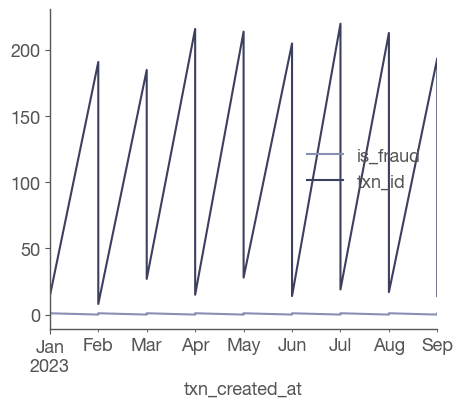

In [209]:
result.plot()

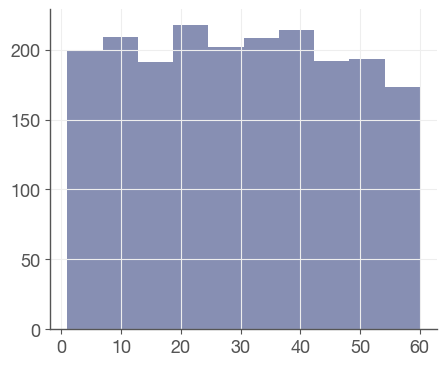

In [210]:
data.settlement_time.hist();

In [52]:
from ydata_profiling import ProfileReport

In [83]:
profile = ProfileReport(data, title="profile report")

In [84]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [199]:
reviews = data.query("was_reviewed==1")[['txn_id','txn_created_at', 'txn_settled_at', 'settlement_time', 'txn_status', 
      'txn_amount',   'is_false_positive', 'frd_min_created_at','frd_max_created_at', 'review_time' ]]

In [200]:
reviews.head()

txn_id      txn_created_at  \
0  txn_584e8e1d-ca48-49a4-b177-06b371950c0a 2023-02-05 08:45:00   
1  txn_cd135ce4-ae09-429f-a17d-315952b2384b 2023-06-04 15:25:00   
2  txn_798033f4-8081-433a-8cf0-b8ab058cf7bb 2023-01-29 14:36:00   
3  txn_7efd21c2-9c3b-4e1f-8d58-fc390ff1e6c5 2023-09-05 04:10:00   
4  txn_42987531-2c95-4b47-829a-fb0d005c5254 2023-03-30 02:26:00   

       txn_settled_at  settlement_time txn_status  txn_amount  \
0 2023-02-05 08:59:00             14.0     failed     -8274.0   
1 2023-06-04 16:16:00             51.0  completed       658.0   
2 2023-01-29 15:34:00             58.0  completed      9112.0   
3 2023-09-05 04:16:00              6.0     failed     -3918.0   
4 2023-03-30 02:41:00             15.0  completed      3384.0   

   is_false_positive         frd_min_created_at         frd_max_created_at  \
0                0.0                        NaT                        NaT   
1                0.0                        NaT                        NaT   
2                0.0                        NaT                        NaT   
3                0.0 2023-06-26 15:27:46.149586 2023-09-22 04:08:32.957684   
4                0.0                        NaT                        NaT   

   review_time  
0          NaN  
1          NaN  
2          NaN  
3   -70.529327  
4          NaN

In [201]:
reviews.txn_status.value_counts()

txn_status
completed    339
failed       168
Name: count, dtype: int64

<Axes: >

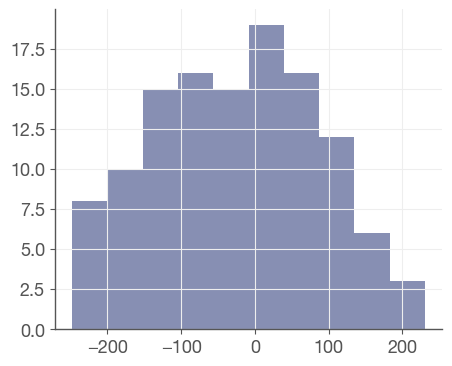

In [202]:
reviews.review_time.hist()

In [213]:
fraud_decisions.query("txn_id=='txn_7efd21c2-9c3b-4e1f-8d58-fc390ff1e6c5'")

accounts_id  \
188  accts_164372ba-86ab-4878-aef0-769ab783f40f   
189  accts_164372ba-86ab-4878-aef0-769ab783f40f   
190  accts_164372ba-86ab-4878-aef0-769ab783f40f   
191  accts_164372ba-86ab-4878-aef0-769ab783f40f   
192  accts_164372ba-86ab-4878-aef0-769ab783f40f   
193  accts_164372ba-86ab-4878-aef0-769ab783f40f   

                                       txn_id                 created_at  \
188  txn_7efd21c2-9c3b-4e1f-8d58-fc390ff1e6c5 2023-06-26 15:27:46.149586   
189  txn_7efd21c2-9c3b-4e1f-8d58-fc390ff1e6c5 2023-06-26 17:29:28.589892   
190  txn_7efd21c2-9c3b-4e1f-8d58-fc390ff1e6c5 2023-06-26 16:50:13.047811   
191  txn_7efd21c2-9c3b-4e1f-8d58-fc390ff1e6c5 2023-09-22 02:35:04.405190   
192  txn_7efd21c2-9c3b-4e1f-8d58-fc390ff1e6c5 2023-09-22 04:08:32.957684   
193  txn_7efd21c2-9c3b-4e1f-8d58-fc390ff1e6c5 2023-09-22 02:50:08.988619   

    reviewer_id  is_false_positive    decision  \
188        John                  0  Legitimate   
189         Bob                  0  Legitimate   
190         Bob                  0  Legitimate   
191       Alice                  0  Legitimate   
192       Alice                  0  Legitimate   
193   Catherine                  0  Legitimate   

                                           id  
188  frd_0430c835-9a11-4fda-b8fa-7f3dc09a4c92  
189  frd_f2dc0603-7866-41d9-8147-ea48d1aaedac  
190  frd_466dbd22-0e87-4f21-832a-9e0f0e68fb9e  
191  frd_1f7ba9a1-8429-464d-9546-0500e443f831  
192  frd_526e4a72-0604-4af3-bf7b-1b73ec7859d5  
193  frd_2121f358-ab36-42d4-b3d5-bfd7de470b11

In [215]:
transactions.query("id=='txn_7efd21c2-9c3b-4e1f-8d58-fc390ff1e6c5'")

id  \
16  txn_7efd21c2-9c3b-4e1f-8d58-fc390ff1e6c5   

                                   accounts_id          created_at  \
16  accts_164372ba-86ab-4878-aef0-769ab783f40f 2023-09-05 04:10:00   

            settled_at  status  amount  
16 2023-09-05 04:16:00  failed -3918.0

Some observations:
- reviews are sometimes multiple months apart (if the timestamp exists)
- some reviews were reviewed before transaction was created?

In [55]:
def plot_fraud_occurrences(df, group_column, title_suffix, decision):

    fraud_normalized = df.groupby(group_column)[decision].value_counts(normalize=True,dropna=False).unstack()

    # Group by the specified column and calculate total value counts
    fraud_counts = df.groupby(group_column)[decision].value_counts()

    # Plotting the normalized fraud occurrences
    ax = fraud_normalized.plot(kind='barh', stacked=True)
    plt.title(f'fraud occurences by {title_suffix}')
    plt.ylabel(title_suffix)
    plt.legend(title=decision, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.show()

    return fraud_normalized

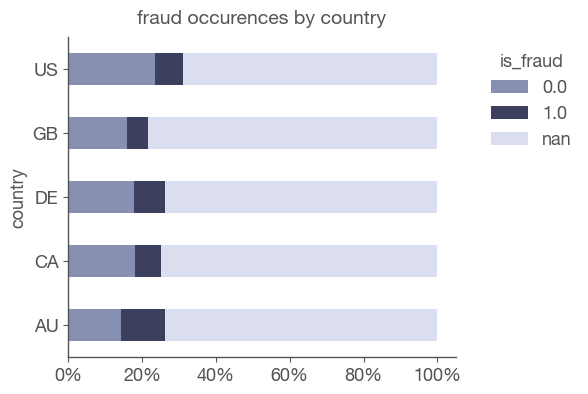

is_fraud          0.0       1.0       NaN
org_country                              
AU           0.142012  0.121302  0.736686
CA           0.179669  0.070922  0.749409
DE           0.179012  0.083333  0.737654
GB           0.160131  0.057190  0.782680
US           0.234323  0.075908  0.689769

In [180]:
plot_fraud_occurrences(data.copy(),'org_country', 'country', 'is_fraud')

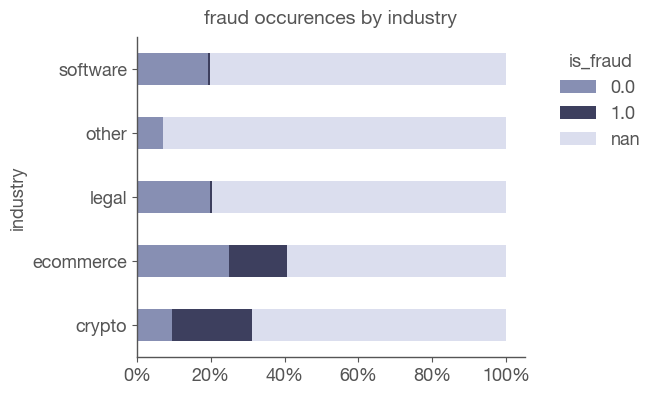

is_fraud           0.0       1.0       NaN
org_industry                              
crypto        0.094303  0.216110  0.689587
ecommerce     0.250000  0.157692  0.592308
legal         0.196937  0.006565  0.796499
other         0.071429       NaN  0.928571
software      0.193416  0.004115  0.802469

In [57]:
plot_fraud_occurrences(data.copy(),'org_industry', 'industry', 'is_fraud')

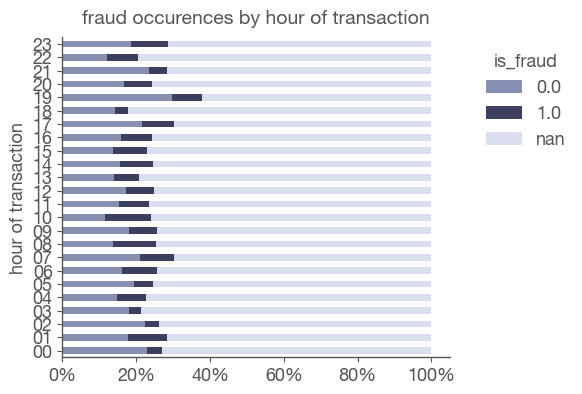

In [58]:
plot_fraud_occurrences(data.copy(),'txn_created_at_hr', 'hour of transaction', 'is_fraud');

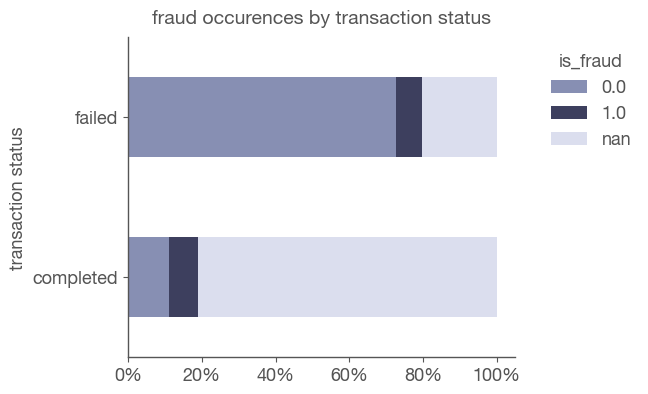

is_fraud         0.0       1.0       NaN
txn_status                              
completed   0.110676  0.078815  0.810509
failed      0.725118  0.071090  0.203791

In [59]:
plot_fraud_occurrences(data.copy(),'txn_status', 'transaction status', 'is_fraud')

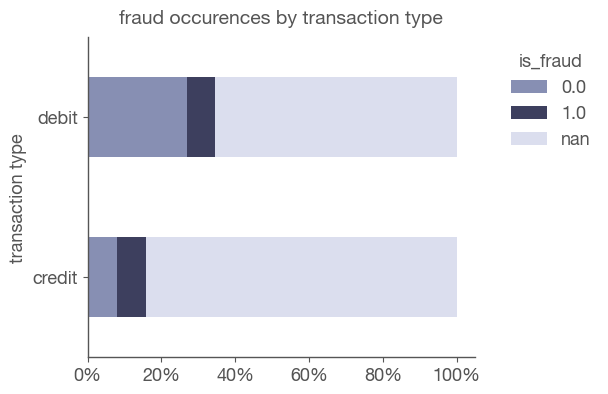

is_fraud       0.0       1.0       NaN
txn_type                              
credit    0.079108  0.079108  0.841785
debit     0.269231  0.076923  0.653846

In [179]:
plot_fraud_occurrences(data.copy(),'txn_type', 'transaction type', 'is_fraud')

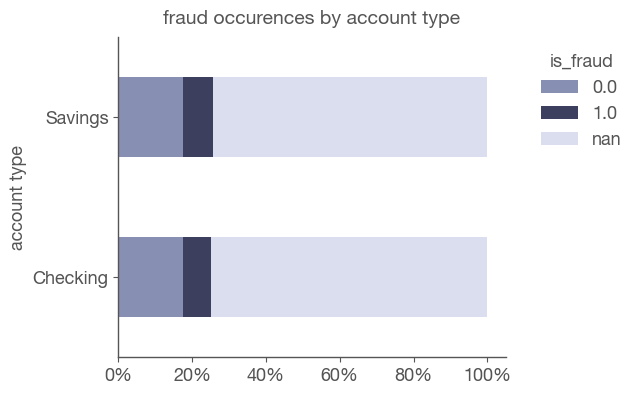

is_fraud           0.0       1.0       NaN
account_type                              
Checking      0.175439  0.075335  0.749226
Savings       0.175558  0.080504  0.743938

In [61]:
plot_fraud_occurrences(data.copy(),'account_type', 'account type', 'is_fraud')

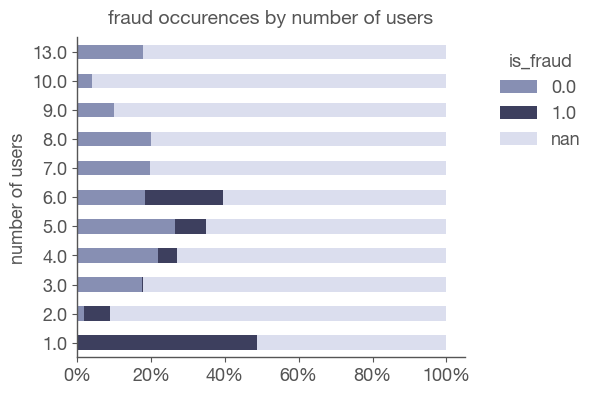

is_fraud            0.0       1.0       NaN
org_num_users                              
1.0                 NaN  0.485714  0.514286
2.0            0.018987  0.069620  0.911392
3.0            0.175182  0.003650  0.821168
4.0            0.217918  0.053269  0.728814
5.0            0.265487  0.084071  0.650442
6.0            0.183374  0.210269  0.606357
7.0            0.195946       NaN  0.804054
8.0            0.200000       NaN  0.800000
9.0            0.098765       NaN  0.901235
10.0           0.040000       NaN  0.960000
13.0           0.178571       NaN  0.821429

In [62]:
plot_fraud_occurrences(data.copy(),'org_num_users', 'number of users', 'is_fraud')

In [63]:
data.columns

Index(['txn_id', 'accounts_id', 'org_id', 'txn_created_at',
       'txn_created_at_hr', 'txn_settled_at', 'txn_status', 'txn_amount',
       'txn_type', 'account_type', 'accts_created_at', 'accts_is_closed',
       'org_website', 'org_has_website', 'org_created_at', 'org_is_active',
       'org_country', 'org_industry', 'is_fraud', 'is_legitimate',
       'is_false_positive', 'frd_max_created_at', 'frd_min_created_at',
       'total_decisions', 'was_reviewed', 'org_num_users',
       'min_usr_created_at', 'max_usr_created_at', 'txn_count_7d',
       'avg_txn_amount_7d', 'high_value_txn_count_7d', 'benford_ones_digit',
       'settlement_rate'],
      dtype='object')

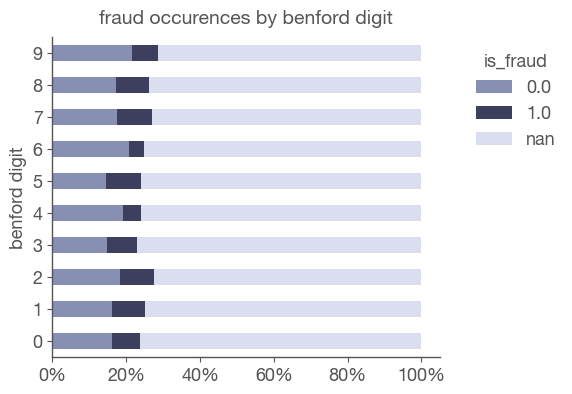

is_fraud                 0.0       1.0       NaN
benford_ones_digit                              
0                   0.160804  0.075377  0.763819
1                   0.161137  0.090047  0.748815
2                   0.182266  0.093596  0.724138
3                   0.148325  0.081340  0.770335
4                   0.190045  0.049774  0.760181
5                   0.146341  0.092683  0.760976
6                   0.207101  0.041420  0.751479
7                   0.174129  0.094527  0.731343
8                   0.173184  0.089385  0.737430
9                   0.216749  0.068966  0.714286

In [64]:
plot_fraud_occurrences(data.copy(),'benford_ones_digit', 'benford digit', 'is_fraud')

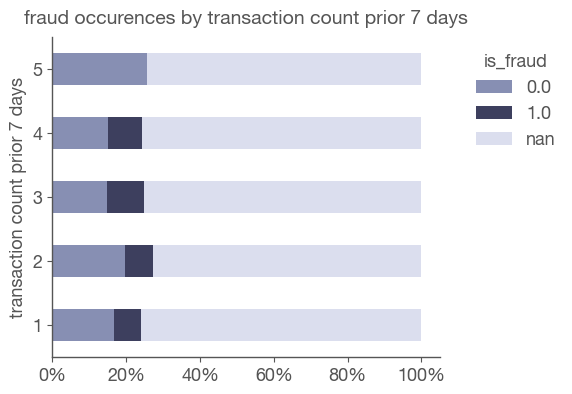

is_fraud           0.0       1.0       NaN
txn_count_7d                              
1             0.167568  0.072973  0.759459
2             0.197260  0.073973  0.728767
3             0.148760  0.099174  0.752066
4             0.151515  0.090909  0.757576
5             0.257143       NaN  0.742857

In [65]:
plot_fraud_occurrences(data.copy(),'txn_count_7d', 'transaction count prior 7 days', 'is_fraud')

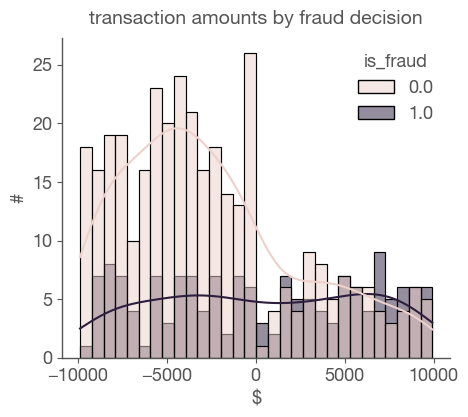

In [66]:
sns.histplot(data=data, x='txn_amount', hue='is_fraud', bins=30, kde=True)
plt.title('transaction amounts by fraud decision')
plt.xlabel('$')
plt.ylabel('#')
plt.show()

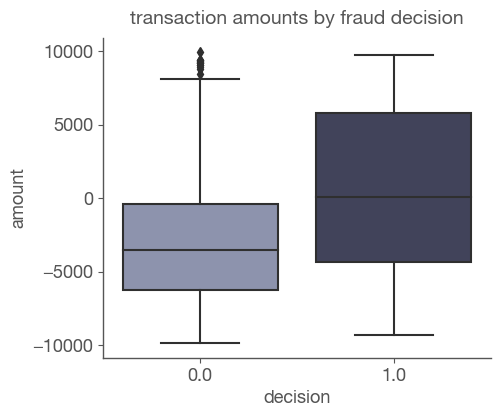

In [67]:
sns.boxplot(x='is_fraud',y='txn_amount',data=data)
plt.title('transaction amounts by fraud decision')
plt.xlabel('decision')
plt.ylabel('amount');

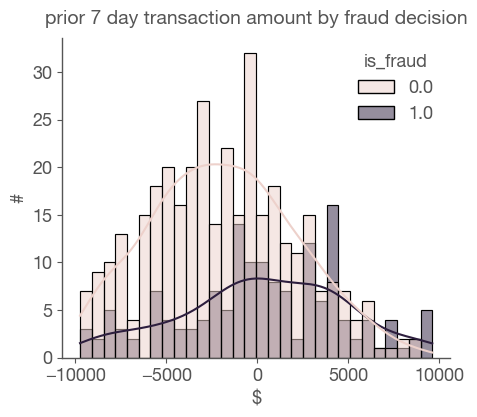

In [68]:
sns.histplot(data=data, x='avg_txn_amount_7d', hue='is_fraud', bins=30, kde=True)
plt.title('prior 7 day transaction amount by fraud decision')
plt.xlabel('$')
plt.ylabel('#')
plt.show()

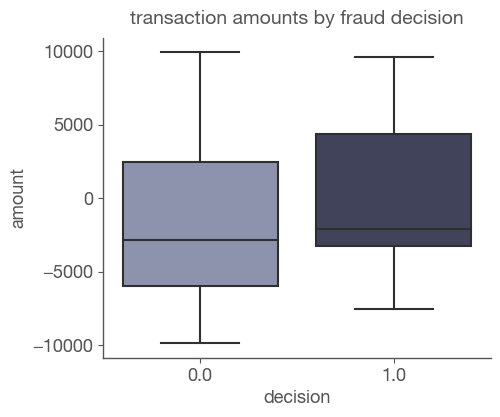

In [69]:
sns.boxplot(x='is_false_positive',y='txn_amount',data=data)
plt.title('transaction amounts by fraud decision')
plt.xlabel('decision')
plt.ylabel('amount');

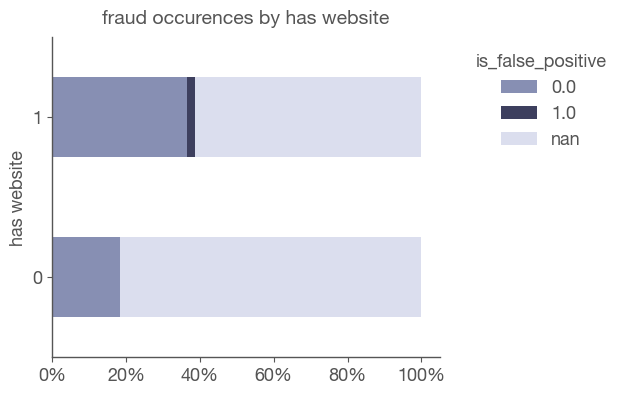

is_false_positive       0.0       1.0       NaN
org_has_website                                
0                  0.183751       NaN  0.816249
1                  0.366032  0.021962  0.612006

In [70]:
plot_fraud_occurrences(data.copy(),'org_has_website', 'has website', 'is_false_positive')

In [279]:
data.to_csv("data.csv", index=False)